In [23]:
# Work at creating some interesting visuals for transit with R
# repos=install.packages("RCurl", repos="https://cran.cnr.berkeley.edu/")
# repos=install.packages("RJSONIO", repos="https://cran.cnr.berkeley.edu/")
# repos=install.packages("plyr", repos="https://cran.cnr.berkeley.edu/")
# install.packages("RPostgreSQL", repos="https://cran.cnr.berkeley.edu/")
# install.packages("ggmap", repos="https://cran.cnr.berkeley.edu/")

require("RPostgreSQL")
library(RCurl)
library(RJSONIO)
library(plyr)
library(ggplot2)
library(ggmap)
library(data.table)

In [24]:
url <- function(address, return.call = "json", sensor = "false", apiKey = "<Your API Key Here>") {
 root <- "https://maps.googleapis.com/maps/api/geocode/"
 # u <- paste(root, return.call, "?address=", address, "&sensor=", sensor, sep = "", "&key=", apiKey)
    u <- paste(root, return.call, "?address=", address, "&sensor=", sensor, "&key=", apiKey, sep = "")
 return(URLencode(u))
}

In [25]:
# This is apparently not how you use the above...
# url(address="1200,+Broadway,+NY,+NY")

In [26]:
geoCode <- function(address,verbose=FALSE) {
 if(verbose) cat(address,"\n")
 u <- url(address)
 doc <- getURL(u)
 x <- fromJSON(doc,simplify = FALSE)
 if(x$status=="OK") {
 lat <- x$results[[1]]$geometry$location$lat
 lng <- x$results[[1]]$geometry$location$lng
 location_type <- x$results[[1]]$geometry$location_type
 formatted_address <- x$results[[1]]$formatted_address
 # return(c(lat, lng, location_type, formatted_address))
 return(x)
 } else {
 return(NA)
 }
}

In [27]:
# Test 
FirstGeo = geoCode("1200 Broadway,NY,NY")
# FirstGeo
length(names(FirstGeo))
# It works!
FirstGeo$results[[1]]$geometry$location

[1] 2

$lat
[1] 40.74617

$lng
[1] -73.98839

In [28]:
# Now connect with our postGreSQL database
# create a connection
# save the password that we can "hide" it as best as we can by collapsing it
pw <- {
  "<Your password here>"
}
hostAWS = '<Your postgresql database host here>'
myPort = <port#>
 
# loads the PostgreSQL driver
drv <- dbDriver("PostgreSQL")
# creates a connection to the postgres database
# note that "con" will be used later in each connection to the database
con <- dbConnect(drv, dbname = "<database-name>",
                 host = hostAWS, port = myPort,
                 user = "<database-username>", password = pw)
rm(pw) # removes the password
 
# check for the cartable
dbExistsTable(con, "for_hire_bases")
# TRUE

[1] TRUE

In [29]:
# Queries
df_postgres <- dbGetQuery(con, "SELECT * from for_hire_bases")
is.data.frame(df_postgres)
 

[1] TRUE

In [30]:
names(df_postgres)

[1] "location_id" "geom"        "longitude"   "latitude"    "name"       
 [6] "telephone"   "has_1040"    "cars"        "add_number"  "add_street" 
[11] "add_city"    "add_state"   "add_zip"     "car_type"    "datn"       
[16] "timn"        "ca"

In [31]:
df_bike_trips <- dbGetQuery(con, "SELECT id, trip_duration, start_time, stop_time, start_station_id, end_station_id, 
birth_year, gender  from bike_trips WHERE start_time BETWEEN '2013-12-1 8:00:00' and '2013-12-1  9:00:00'")

In [32]:
length(df_bike_trips$id)

[1] 271

In [33]:
length(df_bike_trips$id)

[1] 271

In [34]:
range(df_bike_trips$start_time)

[1] "2013-12-01 08:00:23 PST" "2013-12-01 08:59:53 PST"

In [35]:
# Simulate user input
# Input a start and stop point
Addr1 = "357 Wall Street, NY, NY"
Addr2 = "1234 Atlantic Ave, NY, NY"
LongLat1 = geocode(Addr1)
LongLat2 = geocode(Addr2)
LongLat2

#Check distance
Dist = mapdist(from=Addr1, to=Addr2)

# Do Under / Over on distance 
Tol = 0.1
GeoTol = 0.0010
DistMin = Dist$m * (1-Tol)
DistMax = Dist$m * (1+Tol)
DistMax

# Do Under / Over on long and lat for pickup and drop-off
PULonRange = c(LongLat1$lon-GeoTol, LongLat1$lon+GeoTol)
PULatRange = c(LongLat1$lat-GeoTol, LongLat1$lat+GeoTol)
DOLonRange = c(LongLat2$lon-GeoTol, LongLat2$lon+GeoTol)
DOLatRange = c(LongLat2$lat-GeoTol, LongLat2$lat+GeoTol)


Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=357%20Wall%20Street,%20NY,%20NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=1234%20Atlantic%20Ave,%20NY,%20NY&sensor=false


lon     lat
1 -73.95194 40.6784

by using this function you are agreeing to the terms at :
http://code.google.com/apis/maps/documentation/distancematrix/

Information from URL : http://maps.googleapis.com/maps/api/distancematrix/json?origins=357+Wall+Street+NY+NY&destinations=1234+Atlantic+Ave+NY+NY&mode=driving&sensor=false


[1] 9981.4

In [36]:
sqlQuery <- paste("SELECT id, trip_distance, pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, 
dropoff_longitude, dropoff_latitude, total_amount  from trips WHERE (pickup_datetime BETWEEN '2014-12-1 8:00:00' and '2015-12-1  21:00:00') 
AND (pickup_longitude BETWEEN ", PULonRange[1]," AND ", PULonRange[2], ") AND (pickup_latitude BETWEEN ", PULatRange[1],
                  " AND ", PULatRange[2],") AND (dropoff_longitude BETWEEN ", DOLonRange[1]," AND ", DOLonRange[2],
                  ") AND (dropoff_latitude BETWEEN ", DOLatRange[1]," AND ", DOLatRange[2],");", sep = "")
df_trips <- dbGetQuery(con, sqlQuery)
# df_trips <- dbGetQuery(con, "SELECT id, trip_distance, pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, total_amount  from trips WHERE (pickup_datetime BETWEEN '2015-12-1 8:00:00' and '2015-12-1  9:00:00'")

In [37]:
names(df_trips)
df_trips <- data.table(df_trips)

[1] "id"                "trip_distance"     "pickup_datetime"  
[4] "dropoff_datetime"  "pickup_longitude"  "pickup_latitude"  
[7] "dropoff_longitude" "dropoff_latitude"  "total_amount"

In [38]:
df_trips <- na.omit(df_trips)
length(df_trips$id)

[1] 6

In [39]:
# Use mapply (multi-variate sapply) to Create for each row a pickup address and dropoff address (reverse geocode.)

df_trips[, pickup_address:=mapply(function(x,y) {
                                      # return(revgeocode(x))
                                      revgeocode(c(x,y))
                                      return(revgeocode(c(x,y)))
    }, x=pickup_longitude, y=pickup_latitude)
        ]

df_trips[, dropoff_address:=mapply(function(x,y) {
                                      # return(revgeocode(x))
                                      return(revgeocode(c(x,y)))
    }, x=dropoff_longitude, y=dropoff_latitude)
        ]

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.70576095581,-74.013198852539&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.70576095581,-74.013198852539&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705001831054,-74.013023376464&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705001831054,-74.013023376464&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705909729003,-74.013351440429&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705909729003,-74.013351440429&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705577850341,-74.013595581054&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705577850341,-74.013595581054&sensor=false
In

id trip_distance     pickup_datetime    dropoff_datetime
1: 103712772          5.98 2015-07-25 02:33:51 2015-07-25 02:50:40
2:  53041793          5.66 2015-03-08 04:33:02 2015-03-08 04:54:16
3:  55782299          5.70 2015-03-18 22:45:57 2015-03-18 23:07:32
4:  85799122          5.97 2015-06-04 00:04:49 2015-06-04 00:32:56
5:  92231262          6.30 2015-06-25 23:13:17 2015-06-25 23:30:19
6: 139880199          5.90 2015-10-29 12:38:44 2015-10-29 13:09:29
   pickup_longitude pickup_latitude dropoff_longitude dropoff_latitude
1:        -74.01320        40.70576         -73.95223         40.67781
2:        -74.01302        40.70500         -73.95188         40.67846
3:        -74.01335        40.70591         -73.95181         40.67791
4:        -74.01360        40.70558         -73.95181         40.67781
5:        -74.01320        40.70565         -73.95176         40.67843
6:        -74.01321        40.70565         -73.95155         40.67842
   total_amount                          pickup_address
1:        20.30    28 Broadway, New York, NY 10004, USA
2:        25.30 2-12 Beaver St, New York, NY 10004, USA
3:        27.30    2 Morris St, New York, NY 10004, USA
4:        28.80    27 Broadway, New York, NY 10004, USA
5:        27.65    28 Broadway, New York, NY 10004, USA
6:        31.00    28 Broadway, New York, NY 10004, USA

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.677810668945,-73.952232360839&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.678462982177,-73.951881408691&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.677906036376,-73.951805114746&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.677814483642,-73.951805114746&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.678432464599,-73.951759338378&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.678421020507,-73.951553344726&sensor=false


id trip_distance     pickup_datetime    dropoff_datetime
1: 103712772          5.98 2015-07-25 02:33:51 2015-07-25 02:50:40
2:  53041793          5.66 2015-03-08 04:33:02 2015-03-08 04:54:16
3:  55782299          5.70 2015-03-18 22:45:57 2015-03-18 23:07:32
4:  85799122          5.97 2015-06-04 00:04:49 2015-06-04 00:32:56
5:  92231262          6.30 2015-06-25 23:13:17 2015-06-25 23:30:19
6: 139880199          5.90 2015-10-29 12:38:44 2015-10-29 13:09:29
   pickup_longitude pickup_latitude dropoff_longitude dropoff_latitude
1:        -74.01320        40.70576         -73.95223         40.67781
2:        -74.01302        40.70500         -73.95188         40.67846
3:        -74.01335        40.70591         -73.95181         40.67791
4:        -74.01360        40.70558         -73.95181         40.67781
5:        -74.01320        40.70565         -73.95176         40.67843
6:        -74.01321        40.70565         -73.95155         40.67842
   total_amount                          pickup_address
1:        20.30    28 Broadway, New York, NY 10004, USA
2:        25.30 2-12 Beaver St, New York, NY 10004, USA
3:        27.30    2 Morris St, New York, NY 10004, USA
4:        28.80    27 Broadway, New York, NY 10004, USA
5:        27.65    28 Broadway, New York, NY 10004, USA
6:        31.00    28 Broadway, New York, NY 10004, USA
                              dropoff_address
1:   1223 Pacific St, Brooklyn, NY 11216, USA
2: 1234 Atlantic Ave, Brooklyn, NY 11216, USA
3:   1229 Pacific St, Brooklyn, NY 11216, USA
4:   1229 Pacific St, Brooklyn, NY 11216, USA
5: 1234 Atlantic Ave, Brooklyn, NY 11216, USA
6: 1238 Atlantic Ave, Brooklyn, NY 11216, USA

In [40]:
start_long = df_trips[1,pickup_longitude]
start_lat = df_trips[1,pickup_latitude]
# end_long = df_trips[2,dropoff_longitude]
# end_lat = df_trips[2,dropoff_latitude]
# revgeocode(c(start_long,start_lat))
# revgeocode(c(end_long,end_lat))
# 
# start_long
# start_lat

# Create a route for all of the trip rows we've extracted so far.
## Much as I regret it, I was driven to use a loop as mapply returned individual routes as columns and I didn't find
## an obvious way to get the concatenated output in the format I wanted.

# Initialize the legs route
df_leg = data.frame()

NumRows = dim(df_trips)[1]
# NumRows = 1

for (i in (1:NumRows)) { 
    Foghorn_Leghorn = route(from=df_trips$pickup_address[i], to=df_trips$dropoff_address[i], alternatives=FALSE)
    df_leg <- rbind(df_leg, Foghorn_Leghorn)
}

# df_legnormal = route(from=df_trips$pickup_address[1], to=df_trips$dropoff_address[1], alternatives=FALSE)

# ?route
# names(df_leg)
# df_leg
# df_leg

Information from URL : http://maps.googleapis.com/maps/api/directions/json?origin=28+Broadway,+New+York,+NY+10004,+USA&destination=1223+Pacific+St,+Brooklyn,+NY+11216,+USA&mode=driving&units=metric&alternatives=false&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/directions/json?origin=2-12+Beaver+St,+New+York,+NY+10004,+USA&destination=1234+Atlantic+Ave,+Brooklyn,+NY+11216,+USA&mode=driving&units=metric&alternatives=false&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/directions/json?origin=2+Morris+St,+New+York,+NY+10004,+USA&destination=1229+Pacific+St,+Brooklyn,+NY+11216,+USA&mode=driving&units=metric&alternatives=false&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/directions/json?origin=27+Broadway,+New+York,+NY+10004,+USA&destination=1229+Pacific+St,+Brooklyn,+NY+11216,+USA&mode=driving&units=metric&alternatives=false&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/directions/json?

m    km     miles seconds     minutes       hours  startLon startLat
1   126 0.126 0.0782964      37  0.61666667 0.010277778 -74.01332 40.70566
2   107 0.107 0.0664898      37  0.61666667 0.010277778 -74.01328 40.70454
3   127 0.127 0.0789178      48  0.80000000 0.013333333 -74.01313 40.70358
4   201 0.201 0.1249014      76  1.26666667 0.021111111 -74.01162 40.70357
5    44 0.044 0.0273416       8  0.13333333 0.002222222 -74.01117 40.70180
6   283 0.283 0.1758562      34  0.56666667 0.009444444 -74.01167 40.70168
7   749 0.749 0.4654286      40  0.66666667 0.011111111 -74.00987 40.70193
8   985 0.985 0.6120790     106  1.76666667 0.029444444 -74.00294 40.70613
9  2606 2.606 1.6193684     307  5.11666667 0.085277778 -74.00333 40.71114
10  366 0.366 0.2274324      71  1.18333333 0.019722222 -73.98912 40.69217
11 3684 3.684 2.2892376     659 10.98333333 0.183055556 -73.99069 40.68914
12   81 0.081 0.0503334      30  0.50000000 0.008333333 -73.94969 40.67838
13  213 0.213 0.1323582      60  1.00000000 0.016666667 -73.94977 40.67766
14   53 0.053 0.0329342      15  0.25000000 0.004166667 -74.01270 40.70501
15   55 0.055 0.0341770      23  0.38333333 0.006388889 -74.01333 40.70504
16  107 0.107 0.0664898      37  0.61666667 0.010277778 -74.01328 40.70454
17  127 0.127 0.0789178      48  0.80000000 0.013333333 -74.01313 40.70358
18  201 0.201 0.1249014      76  1.26666667 0.021111111 -74.01162 40.70357
19   44 0.044 0.0273416       8  0.13333333 0.002222222 -74.01117 40.70180
20  283 0.283 0.1758562      34  0.56666667 0.009444444 -74.01167 40.70168
21  749 0.749 0.4654286      40  0.66666667 0.011111111 -74.00987 40.70193
22  985 0.985 0.6120790     106  1.76666667 0.029444444 -74.00294 40.70613
23 2606 2.606 1.6193684     307  5.11666667 0.085277778 -74.00333 40.71114
24  366 0.366 0.2274324      71  1.18333333 0.019722222 -73.98912 40.69217
25 3495 3.495 2.1717930     635 10.58333333 0.176388889 -73.99069 40.68914
26   44 0.044 0.0273416      13  0.21666667 0.003611111 -74.01389 40.70605
27  450 0.450 0.2796300     122  2.03333333 0.033888889 -74.01437 40.70621
28  300 0.300 0.1864200      82  1.36666667 0.022777778 -74.01167 40.70966
29  145 0.145 0.0901030      56  0.93333333 0.015555556 -74.01011 40.71208
30  246 0.246 0.1528644      86  1.43333333 0.023888889 -74.00864 40.71140
31  250 0.250 0.1553500      29  0.48333333 0.008055556 -74.00585 40.71198
32 2606 2.606 1.6193684     309  5.15000000 0.085833333 -74.00333 40.71114
33  366 0.366 0.2274324      71  1.18333333 0.019722222 -73.98912 40.69217
34 3684 3.684 2.2892376     659 10.98333333 0.183055556 -73.99069 40.68914
35   81 0.081 0.0503334      30  0.50000000 0.008333333 -73.94969 40.67838
36  171 0.171 0.1062594      51  0.85000000 0.014166667 -73.94977 40.67766
37  132 0.132 0.0820248      34  0.56666667 0.009444444 -74.01349 40.70566
38  192 0.192 0.1193088      51  0.85000000 0.014166667 -74.01425 40.70464
39  189 0.189 0.1174446      43  0.71666667 0.011944444 -74.01646 40.70488
40   68 0.068 0.0422552      22  0.36666667 0.006111111 -74.01601 40.70652
41  190 0.190 0.1180660      21  0.35000000 0.005833333 -74.01578 40.70711
42 3031 3.031 1.8834634     212  3.53333333 0.058888889 -74.01510 40.70580
43   11 0.011 0.0068354       4  0.06666667 0.001111111 -74.00469 40.68029
44 1509 1.509 0.9376926     128  2.13333333 0.035555556 -74.00468 40.68019
45 4468 4.468 2.7764152     862 14.36666667 0.239444444 -73.99867 40.69038
46   81 0.081 0.0503334      30  0.50000000 0.008333333 -73.94969 40.67838
47  171 0.171 0.1062594      51  0.85000000 0.014166667 -73.94977 40.67766
48  126 0.126 0.0782964      37  0.61666667 0.010277778 -74.01332 40.70566
49  107 0.107 0.0664898      37  0.61666667 0.010277778 -74.01328 40.70454
50  127 0.127 0.0789178      48  0.80000000 0.013333333 -74.01313 40.70358
51  201 0.201 0.1249014      76  1.26666667 0.021111111 -74.01162 40.70357
52   44 0.044 0.0273416       8  0.13333333 0.002222222 -74.01117 40.70180
53  283 0.283 0.1758562      34

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.70576095581,-74.013198852539&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=28+Broadway,+New+York,+NY+10004,+USA&zoom=12&size=640x640&scale=2&maptype=hybrid&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=28%20Broadway,%20New%20York,%20NY%2010004,%20USA&sensor=false


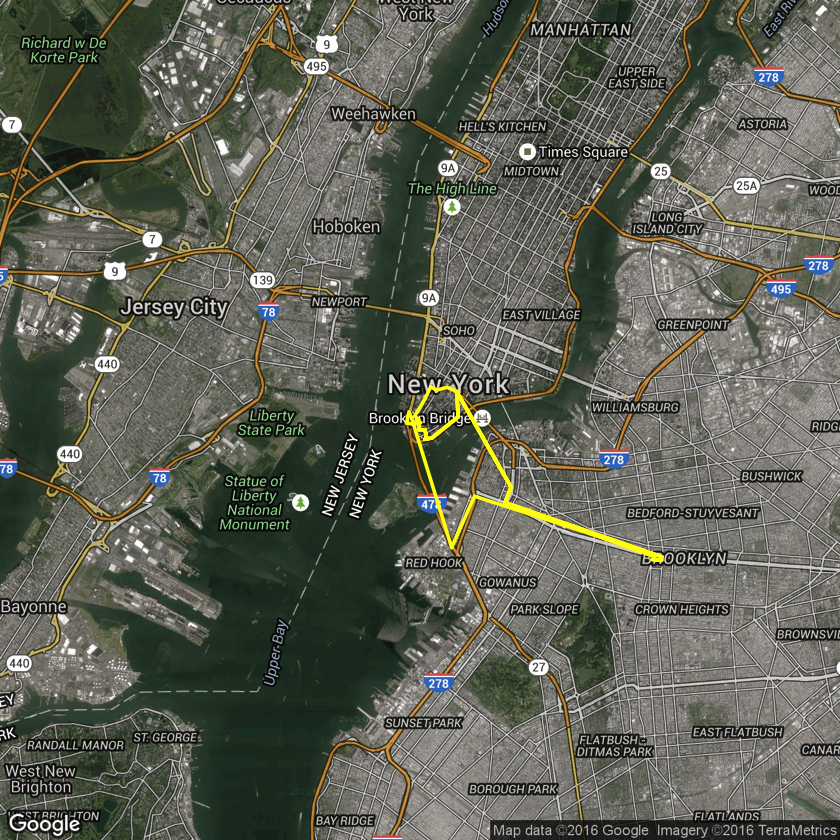

In [41]:
# Now it's time to play around with geographic information systems!
#map <- get_map(
#   location = geocode('123 Wall Street NY, NY'), 
#     source = "google", zoom = 13
# )
# ggmap(map)

# ggplot(data = legs_df) +
# inset_ggmap(map) +
# geom_leg( aes(x = startLon, y = startLat, xend = endLon, yend = endLat, color=route), data=legs_df) + coord_map()
         

qmap(revgeocode(c(start_long,start_lat)), zoom = 12, maptype='hybrid',  
base_layer = ggplot(aes(x = startLon, y = startLat), data = df_leg)) +
geom_leg(aes(x = startLon, y = startLat, xend = endLon, yend = endLat), colour='Yellow', alpha =1, size = 1, data = df_leg) +
labs(x = 'Longitude', y = 'Latitude', colour = 'Route')
# facet_wrap(~ route, ncol = 3) + theme(legend.position = 'top')

In [ ]:
?geom_leg

In [ ]:
dim(df_trips)[1]

In [ ]:
length(df_trips$dropoff_address)